##### Metody obliczeniowe w nauce i technice

## Laboratorium 7 - Dekompozycja spektralna

### Sprawozdanie sporządził: Marcin Zielonka

### Wstęp

Do realizacji zadań skorzystam z gotowych funkcjonalności zawartych w bibliotekach:
* `numpy`
* `scipy`
* `matplotlib`
* `time`

In [173]:
import numpy as np
import scipy.linalg
from matplotlib import pyplot as plt
import time

Do realizacji obu zadań utworzę funkcję pomocniczą, która tworzy macierz symetryczną n x n:

### Zadanie 1: Prosty ranking wierzchołków

In [302]:
def random_symmetric_matrix(N):
    A = np.random.rand(N, N)
    return (A + A.T) / 2

Napisz funkcję obliczającą metodą potęgową dominującą wartość własną (największą co do modułu) i odpowiadający jej wektor własny dla danej macierzy rzeczywistej symetrycznej. Sprawdź poprawność działania programu porównując własną implementację z wynikami funkcji bibliotecznej. Przedstaw na wykresie zależność czasu obliczeń od rozmiaru macierzy (rozmiary macierzy 100x100, 500x500, ...).

* Powtarzaj mnożenie wektora xi przez macierz A: $$\mathbf{x}_{i+1}=\mathbf{A}x_i$$ dzieląc za każdym razem wektor wynikowy przez $\lvert\lvert x_{i+1} \rvert\rvert_\infty$

* Element wektora $\mathbf{x}_i$ o największej wartości bezwzględnej zbiega do dominującej wartości własnej

* Przeskalowany wektor $\mathbf{x}_i$ zbiega do dominującego wektora własnego

* Obliczenia powinny się zatrzymać po przekroczeniu maksymalnej liczby iteracji, albo w przypadku gdy $\lvert\lvert \mathbf{x}_i−\mathbf{x}_{i+1} \rvert\rvert<\epsilon$ (kryterium małej poprawki)

* Pod koniec obliczeń znormalizuj otrzymany wektor własny

Algorytm implementujący metodę potęgową. Jako wynik zwracana jest dominująca wartość własna oraz odpowiadający jej wektor własny:

In [289]:
def solve_eig(A, max_iterations=10000, epsilon=1e-15):
    
    # x0:
    previous = np.array([[1] * len(A)]).T
    
    # x1:
    current = np.dot(A, previous)
    current /= np.linalg.norm(current, np.inf)
    
    # x2, x3, ...
    for i in range(max_iterations - 2):
        if np.linalg.norm(current - previous) < epsilon:
            break
        
        previous = current
        
        current = np.dot(A, current)
        current /= np.linalg.norm(current)
    
    value = np.dot(np.dot(current.T, A), current).flatten()[0]
    
    return value, current.T.flatten()

Funkcja sprawdzająca poprawność implementacji algorytmu na podstawie porównania wyników z otrzymanymi z wywołania alternatywnej funkcji bibliotecznej z biblioteki `scipy`:

In [293]:
def check_results(n, epsilon):
    attempts = n
    fail = 0
    success = 0
    
    for i in range(n):
        A = random_symmetric_matrix(10)
        
        V1, W1 = solve_eig(A, 20000, epsilon)
        V2, W2 = np.linalg.eig(A)
        
        V1 = np.real(V1)
        V2 = max(np.real(V2))
        
        W1 = abs(np.real(W1))
        W2 = abs(np.real(W2.T[0]))
        
        if np.array(list(map(lambda x: abs(x) <= epsilon, (W1 - W2)))).all() and abs(V1 - V2) <= epsilon:
            success += 1
        else:
            fail += 1
    
    return attempts, fail, success

Przedstawienie na wykresie poprawności wyników ze względu na ich dokładność:

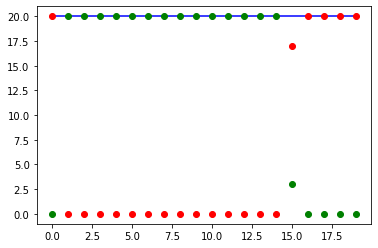

In [294]:
n = 20

alls = []
successes = []
fails = []

for i in range(20):
    epsilon = 10 ** (- i)
    
    attempts, fail, success = check_results(n, epsilon)
    
    alls.append(attempts)
    successes.append(success)
    fails.append(fail)

plt.plot(alls, 'b')
plt.plot(fails, 'ro')
plt.plot(successes, 'go')

plt.show()

Jak widać wyniki są praktycznie identyczne, ponieważ różnią się dopiero przy błędzie rzędu $10^{-15}$.

Funkcja obliczająca czas działania zaimplementowanej funkcji oraz tej dostarczonej z biblioteką `scipy`:

In [298]:
def elapsed_time(A):
    numpy_start = time.time()
    np.linalg.eig(A)
    numpy_end = time.time()
    
    custom_start = time.time()
    solve_eig(A)
    custom_end = time.time()
    
    return (custom_end - custom_start), (numpy_end - numpy_start)

Przedstawienie na wykresie wyników pomiaru ze względu na rozmiar macierzy. Kolor zielony oznacza czasy dla funkcji biblitecznej, a kolor niebieski dla funkcji zaimplementowanej.

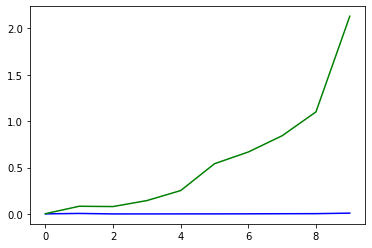

In [301]:
times_custom = []
times_numpy = []

for n in np.linspace(50, 1000, num=10, dtype=int):
    A = random_symmetric_matrix(n)
    
    time_custom, time_numpy = elapsed_time(A)
    
    times_custom.append(time_custom)
    times_numpy.append(time_numpy)
    
plt.plot(times_custom, 'b')
plt.plot(times_numpy, 'g')

plt.show()

Jak widać zaimplementowana funkcja działa szybciej od funkcji bibliotecznej. Jednakże spowodowane jest to najprawdopodobniej faktem, iż funkcja biblioteczna zwraca bardziej szczegółowe wyniki, a zaimplementowana funkcja zwraca tylko jedną wartość własną i związany z nią wektor własny.

### Zadanie 2: Odwrotna metoda potęgowa

Opierając się na twierdzeniu o transformacji widma macierzy:

**Twierdzenie 1**

*Macierz $(\mathbf{A}-\sigma\mathbf{I})^{-1}$ (jeśli istnieje), to ma wartości własne równe $\frac{1}{\lambda_k-\sigma}$ ($\lambda_k$ jest $k$-tą wartością macierz $\mathbf{A}$) i wektory własne identyczne z macierzą $\mathbf{A}$.*

oraz wykorzystując metodę potęgową i faktoryzację $LU$ zaimplementuj odwrotną metodę potęgową pozwalającą na szybkie znalezienie wektorów własnych macierzy $\mathbf{A}$, dla wartości $\sigma$ bliskich odpowiedniej wartości własnej. Wykorzystaj fakt, że mnożenie wektora $\mathbf{x}_i$ przez macierz $\mathbf{A}^{−1}$ ($\mathbf{x}_{i+1}= \mathbf{A}^{−1}\mathbf{x}_i$) odpowiada rozwiązaniu układu równań $\mathbf{Ax}_{i+1}=\mathbf{x}_i$.


Algorytm implementujący odwrotną metodę potęgą z użyciem faktoryzacji $LU$ do rozwiązywnaia układów równań:

In [217]:
def solve_eig_inverse(A, sigma, max_iterations=10000, epsilon=1e-15):
    # obtain LU factors using scipy library
    LU, P = scipy.linalg.lu_factor(A - sigma * np.identity(len(A)))
    
    # x0:
    previous = np.array([[1] * len(A)]).T
    
    # x1:
    # solve equation using LU factorization with scipy library
    current = scipy.linalg.lu_solve((LU, P), previous) 
    current /= np.linalg.norm(current)
    
    for i in range(max_iterations):
        if np.linalg.norm(current - previous) < epsilon:
            break
            
        previous = current
        
        # solve equation using LU factorization with scipy library
        current = scipy.linalg.lu_solve((LU, P), current)
        current /= np.linalg.norm(current)
    
    value = np.dot(np.dot(current.T, A), current).flatten()[0]
    
    return value, current.T.flatten()

Funkcja sprawdzająca poprawność implementacji algorytmu na podstawie porównania wyników z otrzymanymi z wywołania alternatywnej funkcji bibliotecznej z biblioteki `scipy`:

In [283]:
def check_results(n, epsilon):
    attempts = n
    fail = 0
    success = 0
    
    for i in range(n):
        A = random_symmetric_matrix(10)
        
        V2, W2 = np.linalg.eig(A)
        # adding random value to simulate sigma near the eigenvalue:
        V1, W1 = solve_eig_inverse(A, max(V2) + np.random.rand(), 20000, epsilon)
        
        V1 = np.real(V1)
        V2 = max(np.real(V2))
        
        W1 = abs(np.real(W1))
        W2 = abs(np.real(W2.T[0]))
        
        if np.array(list(map(lambda x: abs(x) <= epsilon, (W1 - W2)))).all() and abs(V1 - V2) <= epsilon:
            success += 1
        else:
            fail += 1
    
    return attempts, fail, success

Przedstawienie na wykresie poprawności wyników ze względu na ich dokładność:

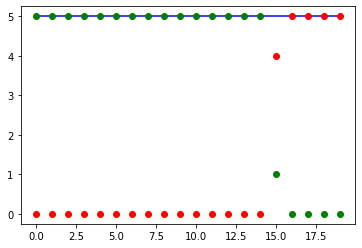

In [285]:
n = 5

alls = []
successes = []
fails = []

for i in range(20):
    epsilon = 10 ** (- i)
    
    attempts, fail, success = check_results(n, epsilon)
    
    alls.append(attempts)
    successes.append(success)
    fails.append(fail)

plt.plot(alls, 'b')
plt.plot(fails, 'ro')
plt.plot(successes, 'go')

plt.show()

Jak widać wyniki są również praktycznie identyczne, ponieważ różnią się dopiero przy błędzie rzędu $10^{−15}$.

Funkcja obliczająca czas działania zaimplementowanych obu funkcji oraz tej dostarczonej z biblioteką `scipy`:

In [286]:
def elapsed_time(A):
    
    numpy_start = time.time()
    V2, _ = np.linalg.eig(A)
    numpy_end = time.time()
    
    eig_inverse_start = time.time()
    solve_eig_inverse(A, max(V2) + np.random.rand())
    eig_inverse_end = time.time()
    
    eig_start = time.time()
    solve_eig(A)
    eig_end = time.time()
    
    return (eig_inverse_end - eig_inverse_start), (eig_end - eig_start), (numpy_end - numpy_start)

Przedstawienie na wykresie wyników pomiaru ze względu na rozmiar macierzy. Kolor zielony oznacza czasy dla funkcji biblitecznej, kolor niebieski dla funkcji implementującej odwrotną metodę potęgową, a kolor czerwony - dla funkcji implementującej metodę potęgową z zadania 1.

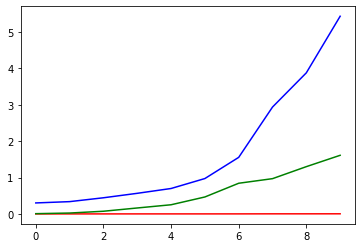

In [287]:
times_eig_inverse = []
times_eig = []
times_numpy = []

for n in np.linspace(50, 1000, num=10, dtype=int):
    A = random_symmetric_matrix(n)
    
    time_eig_inverse, time_eig, time_numpy = elapsed_time(A)
    
    times_eig_inverse.append(time_eig_inverse)
    times_eig.append(time_eig)
    times_numpy.append(time_numpy)
    
plt.plot(times_eig_inverse, 'b')
plt.plot(times_eig, 'r')
plt.plot(times_numpy, 'g')

plt.show()

Jak widać funkcja implementująca metodę potęgową działa szybciej od funkcji bibliotecznej i tej implementującej odwrotną metodę potegową. Jednakże spowodowane jest to najprawdopodobniej faktem, iż funkcja biblioteczna zwraca bardziej szczegółowe wyniki, a funkcja implementująca metodę potęgową zwraca tylko jedną wartość własną i związany z nią wektor własny. Natomiast wysoki czas dla funkcji implementującej odwrotną metodę potęgową jest prawdopodobnie uwarunkowany faktem, iż w trakcie są rozwiązywane układy równań metodą $LU$.